# Linear algebra

In [55]:
import numpy as np
import matplotlib.pyplot as plt

In [56]:
''' Matrix check operations '''

def is_symmetric(matrix):
    np.all(matrix == matrix.T)

def is_orthogonal(matrix):
    rows, cols = matrix.shape
    if rows != cols:
        return False
    
    P = matrix * matrix.T
    I = np.identity(rows)

    return np.allclose(P, I)

The homogeneous transformation matrix that represents pose $ \mathbf{p} = (x, y, \theta)^T $ w.r.t. to the origin $ (0, 0, 0)^T $ of the global coordinate system is given by

\begin{equation}
    \mathbf{P} = \begin{pmatrix}
    \cos{\theta} & -\sin{\theta} & x \\
    \sin{\theta} & \cos{\theta} & y \\
    0 & 0 & 1
    \end{pmatrix}
    = \begin{pmatrix}
    \mathbf{R} & \mathbf{t} \\
    0 & 1 \\
    \end{pmatrix}
\end{equation}

where

\begin{equation}
    \mathbf{R} = \begin{pmatrix}
    \cos{\theta} & -\sin{\theta} \\
    \sin{\theta} & \cos{\theta} \\
    \end{pmatrix}
\end{equation}
\begin{equation}
    \mathbf{t} = \begin{pmatrix}
    x \\
    y \\
    \end{pmatrix}
\end{equation}

In [57]:
def system_matrix(x, y, theta):
    cos = np.cos(theta)
    sin = np.sin(theta)
    return np.array([
        [cos, -sin, x],
        [sin,  cos, y],
        [  0,    0, 1]
    ])

## Coordinate frame transformation


### Local $ \rightarrow $ global

While being at pose $ \mathbf{p_1} = (x_1 , y_1 , θ_1 )^T $, the robot senses a landmark at position
$ \mathbf{l} = (l_x , l_y) $ w.r.t. its local frame.

Coordinates of $ \mathbf{l} $ w.r.t. the global frame are then:

\begin{equation}
    \mathbf{l_{global}} = \mathbf{P} \cdot \mathbf{l_{local}}
\end{equation}

where $ \mathbf{l_{local}} $ is a position vector of a landmark given by


\begin{equation}
    \mathbf{l_{local}} = \begin{pmatrix}
    l_x \\
    l_y \\
    1
    \end{pmatrix}
\end{equation}

In [58]:
def position_vector(x, y):
    return np.array([
        x,
        y,
        1
    ])

Robot's coordinate frame matrix:
[[ 1. -0.  4.]
 [ 0.  1.  2.]
 [ 0.  0.  1.]]
Landmark's position vector:
[-2  5  1]
Landmark's global position:
[2. 7. 1.]


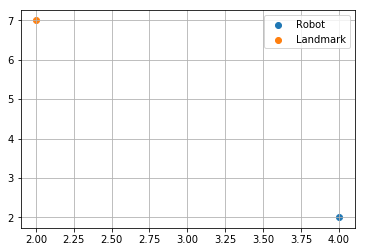

In [59]:
# Robot
x1, y1, theta1 = 4, 2, 0
p1 = (x1, y1, theta1)
P1 = system_matrix(*p1)
print("Robot's coordinate frame matrix:")
print(P1)

# Landmark w.r.t. robot's frame
l_local = position_vector(-2, 5)
print("Landmark's position vector:")
print(l_local)

# Landmark w.r.t. global frame
l_global = P1.dot(l_local)
lx_global = l_global[0]
ly_global = l_global[1]
print("Landmark's global position:")
print(l_global)

# Plot the global positions
plt.scatter([x1], [y1], label = "Robot")
plt.scatter([lx_global], [ly_global], label = "Landmark")

plt.grid()
plt.legend(loc = "best")
plt.show()

### Global $ \rightarrow $ local

Now imagine that you are given the landmark’s coordinates w.r.t. the global frame.
The coordinates that the robot will sense in its local frame are then

\begin{equation}
    \mathbf{l_{local}} = \mathbf{P}^{-1} \cdot \mathbf{l_{global}}
\end{equation}

where the inverse of the system matrix is

\begin{equation}
    \mathbf{P}^{-1} = \begin{pmatrix}
    \mathbf{R}^{T} & -\mathbf{R}^{T}\mathbf{t} \\
    0 & 1 \\
    \end{pmatrix}
\end{equation}


In [60]:
def inv_system_matrix(system_matrix):
    R = system_matrix[0:2, 0:2]
    t = system_matrix[0:2, 2]
    
    R_new = R.T
    t_new = (-R.T).dot(t)
    
    return np.block([
        [R_new, np.expand_dims(t_new, axis = 1)],
        [0, 0, 1]
    ])

In [61]:
# Inverse of the robot's system matrix
P1_inv = inv_system_matrix(P1)
I = np.identity(P1.shape[0])

# Make sure that P1_inv is really an inverse of P1
assert np.allclose(P1.dot(P1_inv), I) 

l_global = position_vector(lx_global, ly_global)
l_local = P1_inv.dot(l_global)
print("Landmark's position in the robot's frame:")
print(l_local)

Landmark's position in the robot's frame:
[-2.  5.  1.]


### Robot's movement

The robot moves to a new pose $ \mathbf{p_2} = (x_2 , y_2 , \theta_2)^T $ w.r.t. the global frame. Now, we want to find the transformation matrix $ \mathbf{T_{12}} $ that represents the new pose $ \mathbf{p_2} $ w.r.t. $ \mathbf{p_1} $. 

\begin{equation}
    \mathbf{P_2} = \mathbf{T_{12}} \cdot \mathbf{P_1}
\end{equation}

In order to do that we are going to write $ \mathbf{T_{12}} $ as a product of homogeneous transformation matrices.


\begin{equation}
    \mathbf{P_{2}} = \mathbf{P_2} \cdot \mathbf{I} = \mathbf{P_2} \cdot \mathbf{P_1}^{-1} \cdot \mathbf{P_1} = \mathbf{T_{12}} \cdot \mathbf{P_1}
\end{equation}

where

\begin{equation}
    \mathbf{T_{12}} = \mathbf{P_2} \cdot \mathbf{P_1}^{-1}
\end{equation}

In [62]:
# Robot's new position
x2, y2, theta2 = 1, 1, np.pi/2
p2 = (x2, y2, theta2)
P2 = system_matrix(*p2)
print("Robot's new coordinate frame matrix:")
print(P2)

# Transformation matrix
print("Transformation matrix from P1 to P2:")
T_12 = P2.dot(P1_inv)
print(T_12)

# Make sure that T_12 transforms P1 to P2
assert np.allclose(P2, T_12.dot(P1))

Robot's new coordinate frame matrix:
[[ 6.123234e-17 -1.000000e+00  1.000000e+00]
 [ 1.000000e+00  6.123234e-17  1.000000e+00]
 [ 0.000000e+00  0.000000e+00  1.000000e+00]]
Transformation matrix from P1 to P2:
[[ 6.123234e-17 -1.000000e+00  3.000000e+00]
 [ 1.000000e+00  6.123234e-17 -3.000000e+00]
 [ 0.000000e+00  0.000000e+00  1.000000e+00]]


The robot is at position $ \mathbf{p_2} $. The landmark's position w.r.t. the robot’s local frame is now:

\begin{equation}
\begin{cases}
    \mathbf{l_{global}} = \mathbf{P_1} \cdot \mathbf{l_{local}^{P_1}} \\
    \mathbf{l_{global}} = \mathbf{P_2} \cdot \mathbf{l_{local}^{P_2}}
\end{cases}
\end{equation}

\begin{equation}
\mathbf{P_1} \cdot \mathbf{l_{local}^{P_1}} = \mathbf{P_2} \cdot \mathbf{l_{local}^{P_2}} \\
\end{equation}

Therefore:

\begin{equation}
    \mathbf{l_{local}^{P_2}} = \mathbf{P_2}^{-1} \cdot \mathbf{P_1} \cdot \mathbf{l_{local}^{P_1}}
\end{equation}

In [63]:
# Landmarks position w.r.t. P2
l_local_P1 = l_local
l_local_P2 = inv_system_matrix(P2).dot(P1).dot(l_local_P1)
print("Landmark's local position vector in the robot's new coordinate frame:")
print(l_local_P2)

Landmark's local position vector in the robot's new coordinate frame:
[ 6. -1.  1.]
